<h1 style="color:Peru;"> Brain Stroke Prediction </h1>

<h3 style="color:DarkOliveGreen;"> Problem Statement </h3>

**Our Aim is to predict whether a patient is likely to get stroke based on the input parameters like gender, age, various diseases, and smoking status.**

<h3 style="color:DarkOliveGreen;"> Import Required Libraries </h3>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

from imblearn.over_sampling import RandomOverSampler

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, roc_auc_score, plot_confusion_matrix

import warnings
warnings.filterwarnings('ignore')

<h3 style="color:DarkOliveGreen;"> Load Dataset </h3>

In [2]:
df = pd.read_csv('../input/stroke-prediction-dataset/healthcare-dataset-stroke-data.csv')

In [3]:
# lets check the first five rows of dataset
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [4]:
# lets check the shape of dataset
df.shape

(5110, 12)

In [5]:
# Let's get an overview of features datatype
df.dtypes

id                     int64
gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

**We can see that Hypertension, heart disease and stroke have an integer data type but we know that they are categorical variables. So lets convert them to object datatype.**

In [6]:
columns_to_convert = ['hypertension', 'heart_disease', 'stroke']
df[columns_to_convert] = df[columns_to_convert].astype(str)

<h3 style="color:DarkOliveGreen;"> Data Description </h3>

1. **id:** unique identifier
1. **gender:** "Male", "Female" or "Other"
1. **age:** age of the patient
1. **hypertension:** 0 if the patient doesn't have hypertension, 1 if the patient has hypertension
1. **heart_disease:** 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease
1. **ever_married:** "No" or "Yes"
1. **work_type:** "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"
1. **Residence_type:** "Rural" or "Urban"
1. **avg_glucose_level:** average glucose level in blood
1. **bmi:** body mass index
1. **smoking_status:** "formerly smoked", "never smoked", "smokes" or "Unknown"*
1. **stroke:** 1 if the patient had a stroke or 0 if not *Note: "Unknown" in smoking_status means that the information is unavailable for this patient

In [7]:
# summary statistics
df.describe().style.background_gradient(cmap = "plasma")

,id,age,avg_glucose_level,bmi
count,5110.000000,5110.000000,5110.000000,4909.000000
mean,36517.829354,43.226614,106.147677,28.893237
std,21161.721625,22.612647,45.283560,7.854067
min,67.000000,0.080000,55.120000,10.300000
25%,17741.250000,25.000000,77.245000,23.500000
50%,36932.000000,45.000000,91.885000,28.100000
75%,54682.000000,61.000000,114.090000,33.100000
max,72940.000000,82.000000,271.740000,97.600000


**It seems like we have some outliers in avg_glucose_level and bmi. we'll check that later in our EDA section.**

<h3 style="color:DarkOliveGreen;"> EDA & Data Cleaning </h3>

In [8]:
# Drop ID - I think, ID won't useful in our analysis.
df.drop('id', axis= 1, inplace= True)

In [9]:
# categorical and numeric features
cat_features = df.select_dtypes(exclude="number").columns
num_cols = df.select_dtypes(include="number").columns
print('Categorical Features are: ', cat_features)
print('Numerical Features are: ', num_cols)

Categorical Features are:  Index(['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type',
       'Residence_type', 'smoking_status', 'stroke'],
      dtype='object')
Numerical Features are:  Index(['age', 'avg_glucose_level', 'bmi'], dtype='object')


In [10]:
# checking for null values
df.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

**Missing values found in bmi. we will impute missing values with the mode of the BMI in sklearn pipeline.**

### **Analysis of Stroke - Target Variable**

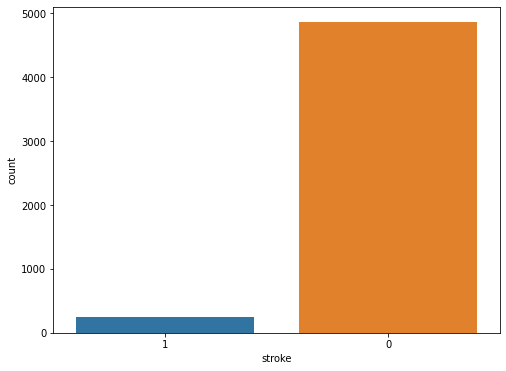

In [11]:
plt.figure(figsize=(8,6))
sns.countplot(x = 'stroke', data = df)
plt.show()

**As we can see that from the above plot, its a class imbalancing problem. The number of people who actually had a stroke are very less in our dataset. We'll use oversampling technique to deal with this.**

### **Analysis of Continuous Features**

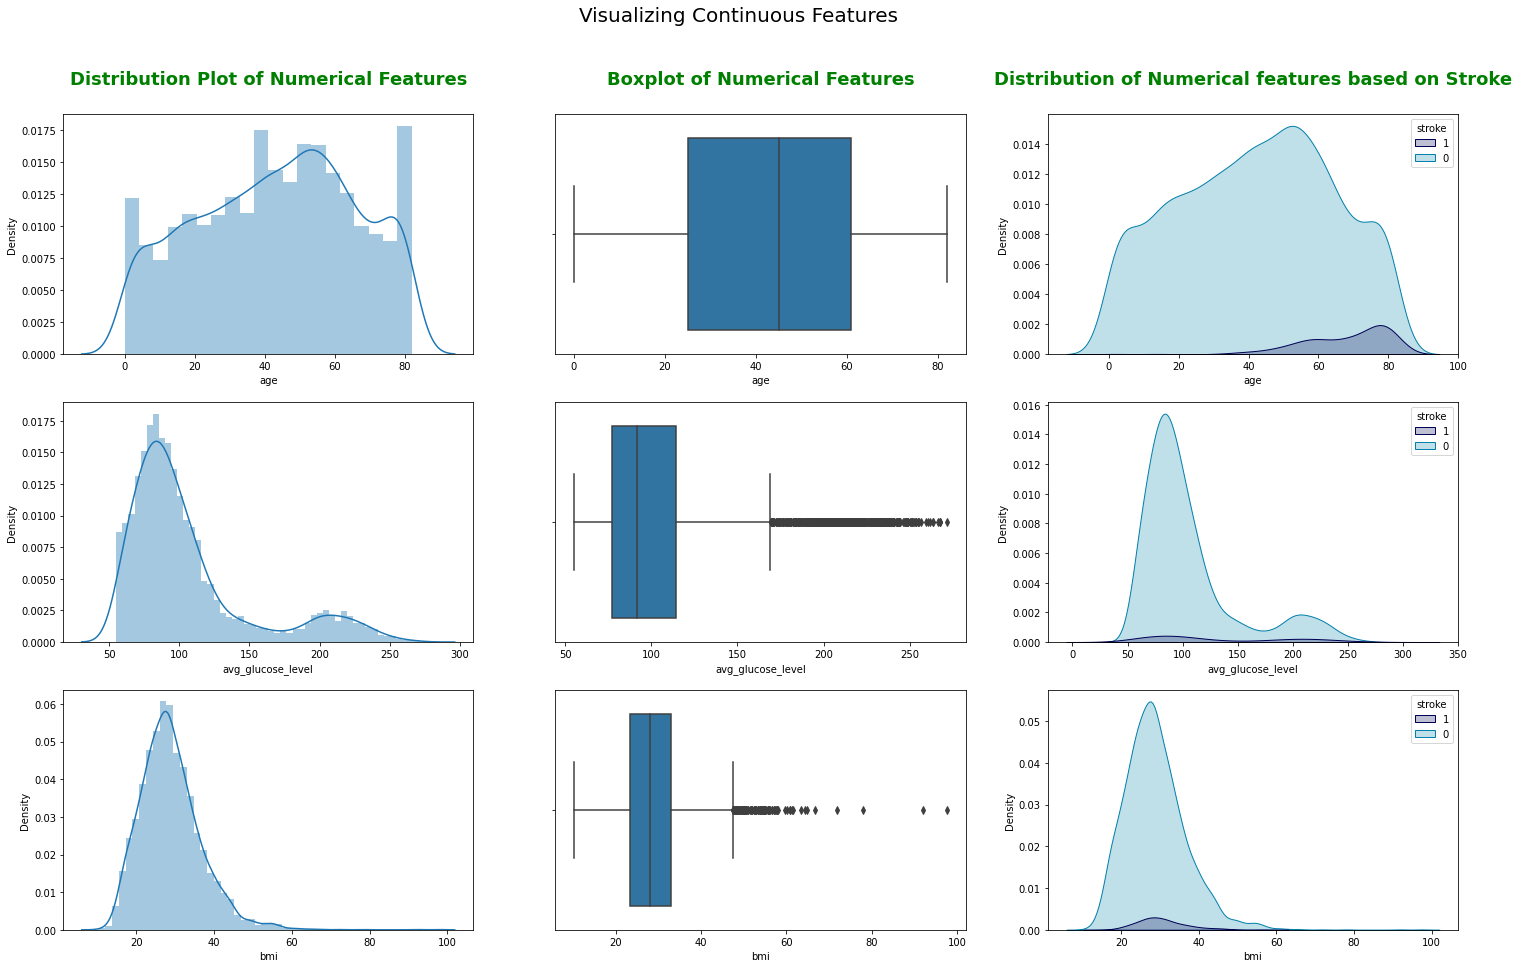

In [12]:
fig,ax=plt.subplots(3,3,figsize=(25,15))
for i,col in enumerate(num_cols):
    plt.suptitle("Visualizing Continuous Features",size=20)
    sns.distplot(df[col], ax=ax[i,0], kde=True)
    sns.boxplot(data=df, x=col, ax=ax[i,1])
    sns.kdeplot(data = df, x = col, hue= 'stroke', shade= True, ax=ax[i,2], palette = 'ocean')
    if i == 0:
        ax[0,0].set_title('Distribution Plot of Numerical Features', loc='center', y=1.1, size=18, weight='bold',color='green')
    elif i==1:
        ax[0,1].set_title('Boxplot of Numerical Features', loc='center', y=1.1, size=18, weight='bold',color='green')
    else:
        ax[0,2].set_title('Distribution of Numerical features based on Stroke', loc='center', y=1.1, size=18, weight='bold',color='green')
    

Insights:<br>
* **We clearly have a lot of outliers in avg_glucose_level and BMI column.**
* **Age Distribution based on Stroke shows that older people have a much higher chance of getting a stroke as compared to younger individuals.**

### **Analysis of Categorical Features**

In [13]:
# Checking value in each categorical feature
cat_cols = cat_features[:-1]
for col in cat_cols:
    print(f'============{col}============\n {df[col].value_counts()}\n')

============gender============
 Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

============hypertension============
 0    4612
1     498
Name: hypertension, dtype: int64

============heart_disease============
 0    4834
1     276
Name: heart_disease, dtype: int64

============ever_married============
 Yes    3353
No     1757
Name: ever_married, dtype: int64

============work_type============
 Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64

============Residence_type============
 Urban    2596
Rural    2514
Name: Residence_type, dtype: int64

============smoking_status============
 never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64



**Only one instance of other category in Gender column. Let's drop it.**

In [14]:
df.drop(df.loc[df['gender'] == 'Other'].index, inplace= True)

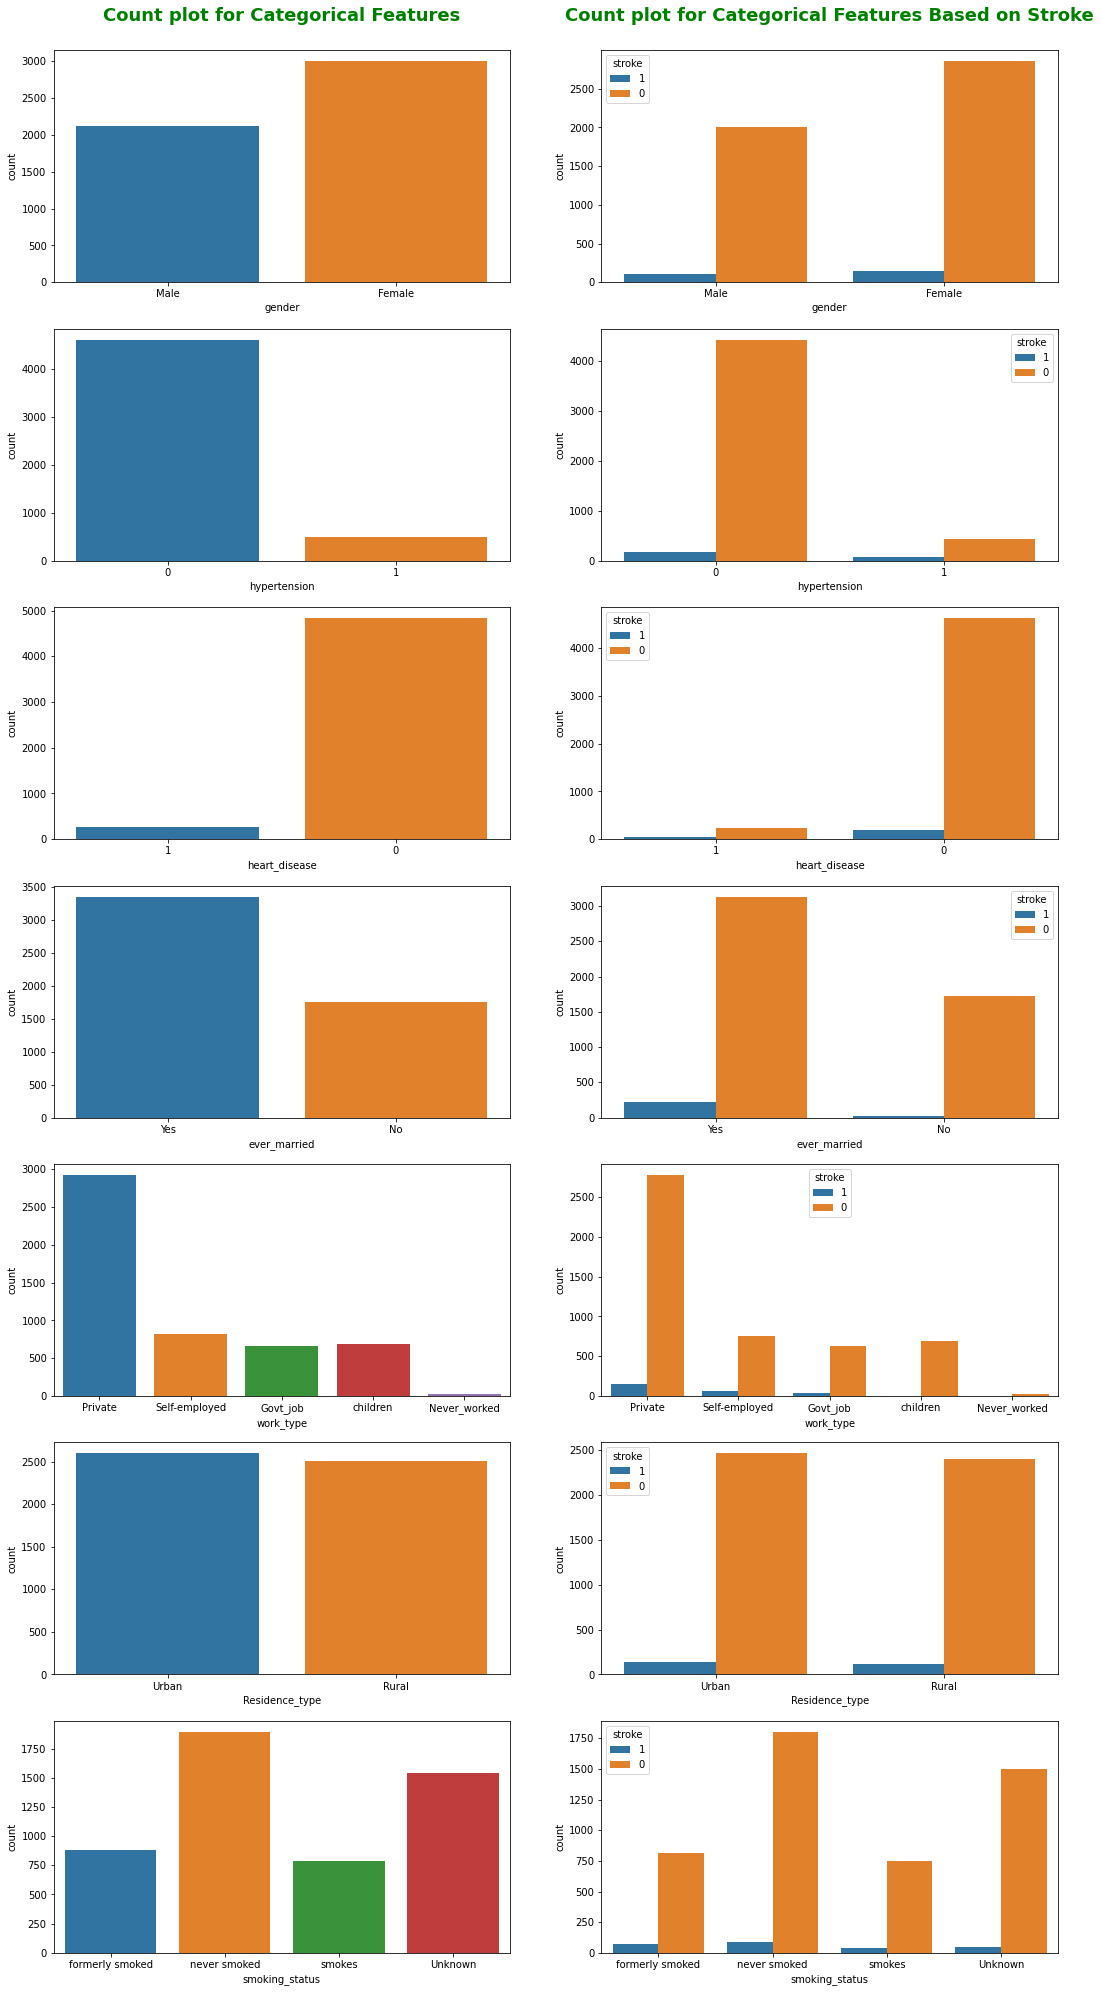

In [15]:
fig,ax = plt.subplots(7,2,figsize=(18,35))
for i, col in enumerate(cat_cols):
    sns.countplot(data = df, x = col, ax=ax[i,0])
    sns.countplot(data = df, x = col,hue='stroke', ax=ax[i,1])
    if i == 0:
        ax[0,0].set_title('Count plot for Categorical Features', loc='center', y=1.1, size=18, weight='bold',color='green')
    else:
        ax[0,1].set_title('Count plot for Categorical Features Based on Stroke', loc='center', y=1.1, size=18, weight='bold',color='green')

Insights:<br>
* **Married people have more strokes as compared to unmarried.**
* **Never smoked people have more strokes as compared to formerly smoked or smokes.**
* **Urban people have more strokes as compared to people living in rural areas.**

<h3 style="color:DarkOliveGreen;"> Data Preprocessing</h3>

In [16]:
# convert target variabe stroke into integer format 
df['stroke'] = df['stroke'].map({'0': 0, '1': 1})

In [17]:
# splitting the data into X and y
X = df.drop('stroke', axis=1)
y = df['stroke']

In [18]:
# For the categorical features, we will encode them with One-Hot encoding
categorical_pipeline = Pipeline(
    steps=[
        ("onehot-encoder", OneHotEncoder(handle_unknown="ignore", sparse=False,drop='first')),
    ]
)

In [19]:
# For the numeric features, specifically 'bmi' we will impute the missing values with the mode of the column
# and StandardScaler so that the features have 0 mean and a variance of 1:
numeric_pipeline = Pipeline(
    steps=[
           ("imputer", SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
           ("scaler", StandardScaler())
         ]
)

In [20]:
# Next, we will input these along with their corresponding pipelines into a ColumnTransFormer instance
full_processor = ColumnTransformer(
    transformers=[
        ("numeric", numeric_pipeline, num_cols),
        ("categorical", categorical_pipeline, cat_cols),
    ]
)

In [21]:
# Apply preprocessing
X_processed = full_processor.fit_transform(X)
y_processed = y.values.reshape(-1,1)
print('X Shape: ', X_processed.shape)
print('y shape: ', y_processed.shape)

X Shape:  (5109, 15)
y shape:  (5109, 1)


### **RandomOversampling**

In [22]:
# Oversampling of Minority Class
ros = RandomOverSampler(sampling_strategy='minority')

X_sample, y_sample = ros.fit_resample(X_processed, y_processed)
print('Original Y Count: ', np.unique(y_processed, return_counts=True))
print('OverSample Y Count: ', np.unique(y_sample, return_counts=True))

Original Y Count:  (array([0, 1]), array([4860,  249]))
OverSample Y Count:  (array([0, 1]), array([4860, 4860]))


<h3 style="color:DarkOliveGreen;"> Model Building</h3>

In [23]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size = 0.3, stratify = y_sample, random_state = 2022)

In [24]:
# Models
models = [ KNeighborsClassifier(n_neighbors = 3),
           SVC(probability=True),
           DecisionTreeClassifier(random_state=2022),
           RandomForestClassifier(random_state=2022),
           XGBClassifier(random_state=2022),
           CatBoostClassifier(random_state=2022,verbose=0)]

model_names=['KNN', 'SVM', 'Decision Tree','Random Forest','XGBoost','CatBoost']

In [25]:
def build_models(models, model_names):
    # lets create an empty lists to append the results
    roc_auc_scores  = []
    accuracy_scores = []
    results = {}
    
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15,10))
    # use enumerate() and zip() function to iterate the lists
    for idx, (ml_model_names, ml_models, ax) in enumerate(zip(model_names, models, axes.flatten())):
        clf = models[idx]
        clf.fit(X_train,y_train)
        y_pred = clf.predict(X_test)
        y_pred_proba = clf.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        accuracy = accuracy_score(y_test, y_pred)
        
        plot_confusion_matrix(clf, 
                              X_test, 
                              y_test, 
                              ax=ax, 
                              cmap='Blues')
        ax.title.set_text(ml_model_names)
        
        print("Model: {}".format(ml_model_names))
        print("Accuracy: {}".format(accuracy))
        print("Roc Auc Score: {}".format(roc_auc))
        print('\n')
        
        
        roc_auc_scores.append(roc_auc)
        accuracy_scores.append(accuracy)
    
    results = {'Model':model_names,
           'ROC AUC Score':roc_auc_scores,
           'Accuracy Score':accuracy_scores}
    plt.tight_layout()  
    plt.show()
    # Put the roc_auc_scores and accuracy scores in a data frame.
    models_scores_df = pd.DataFrame(results)
    return models_scores_df

Model: KNN
Accuracy: 0.9447873799725651
Roc Auc Score: 0.9701646090534979


Model: SVM
Accuracy: 0.8446502057613169
Roc Auc Score: 0.9077451683253646


Model: Decision Tree
Accuracy: 0.970164609053498
Roc Auc Score: 0.9701646090534979


Model: Random Forest
Accuracy: 0.9921124828532236
Roc Auc Score: 1.0


Model: XGBoost
Accuracy: 0.9729080932784636
Roc Auc Score: 0.9974550326376774


Model: CatBoost
Accuracy: 0.960562414266118
Roc Auc Score: 0.9958974749784077




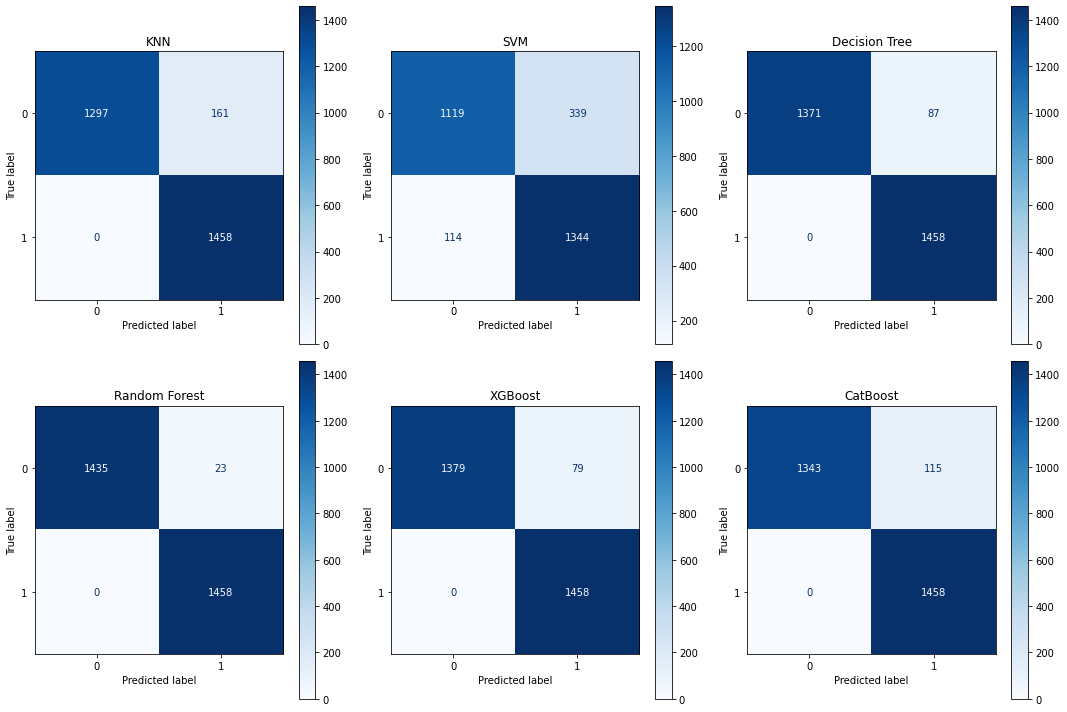

In [26]:
models_scores_df = build_models(models, model_names)

**0 False Negatives. It means we are able to predict all patients who had a stroke.**

In [27]:
models_scores_df

,Model,ROC AUC Score,Accuracy Score
0,KNN,0.970165,0.944787
1,SVM,0.907745,0.844650
2,Decision Tree,0.970165,0.970165
3,Random Forest,1.000000,0.992112
4,XGBoost,0.997455,0.972908
5,CatBoost,0.995897,0.960562


**Based on the above results, we can conclude that the Random Forest is best suited for this classification, closely followed by Decision Tree, XGBoost and CatBoost.**